# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: October, 2025

**Student Name**: Vicente Sebastian Serrano Cabrera

**Professor**: Pablo Camarillo Ramirez

python3 lib/Modulo_Sebas/producerValo.py kafka:9093 valorant-topic data/valorant_events.csv

Es la liena con la que corremos el producer que creamos en mi modulo de lib

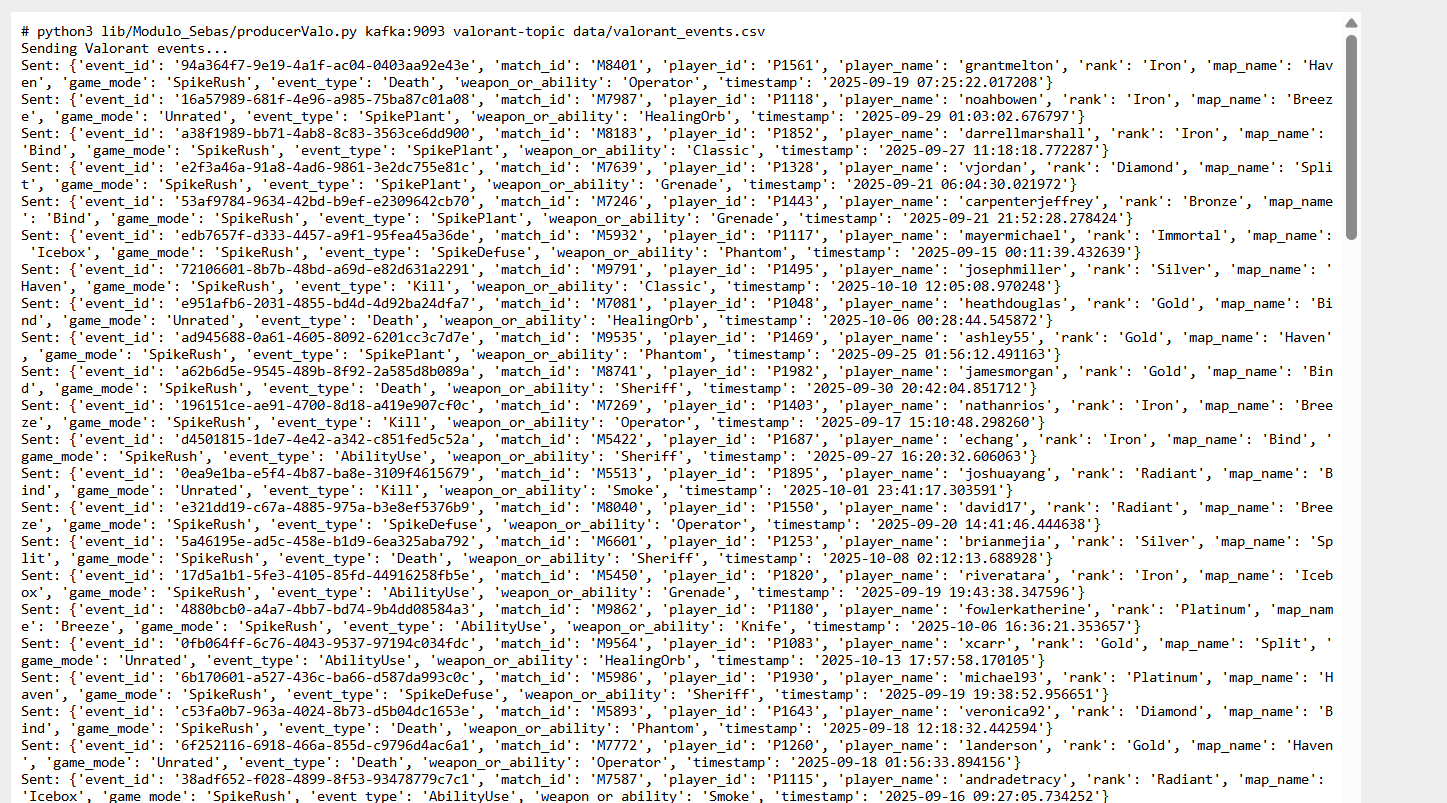

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Structured Streaming (Project)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-81c80d6f-e085-402a-83f3-46571e0dc026;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Consumer

## Dataset and Stream creation

In [2]:
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "valorant-topic") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [3]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructField, StringType
from pcamarillor.spark_utils import SparkUtils
valo_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

schema_columns = [
    ("event_id", "string"),
    ("match_id", "string"),
    ("player_id", "string"),
    ("player_name", "string"),
    ("rank", "string"),
    ("map_name", "string"),
    ("game_mode", "string"),
    ("event_type", "string"),
    ("weapon_or_ability", "string"),
    ("timestamp", "string")
]

pkg_schema = SparkUtils.generate_schema(schema_columns)
valo_extracted_df = valo_df.withColumn("telemetry", from_json(valo_df.value_str, pkg_schema))
valo_extracted_df = valo_extracted_df.select("telemetry.*")
valo_extracted_df.printSchema()            

root
 |-- event_id: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- player_id: string (nullable = true)
 |-- player_name: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- map_name: string (nullable = true)
 |-- game_mode: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- weapon_or_ability: string (nullable = true)
 |-- timestamp: string (nullable = true)



## Transformations and Actions

In [4]:
from pyspark.sql.functions import to_timestamp, to_date, hour, when, count, avg, year, month, day

valo_transformed_df = valo_extracted_df \
    .withColumn("timestamp", to_timestamp(col("timestamp"))) \
    .withColumn("event_date", to_date(col("timestamp"))) \
    .withColumn("event_hour", hour(col("timestamp"))) \
    .withColumn(
        "critical_event",
        when(col("event_type").isin(["Kill", "SpikePlant", "SpikeDefuse"]), 1).otherwise(0))

valo_clean_df = valo_transformed_df.dropna(subset=[
    "player_id",
    "player_name",
    "rank",
    "match_id",
    "event_type",
    "timestamp",
    "map_name"
]).dropDuplicates()


df_player_stats = valo_clean_df \
    .withWatermark("timestamp", "5 minutes") \
    .groupBy(
    col("player_id"),
    col("player_name"),
    col("rank"),
    col("timestamp")
).agg(
    count("critical_event").alias("total_critical_events")
)

df_map_stats = valo_clean_df \
    .withWatermark("timestamp", "5 minutes") \
    .groupBy(
    col("map_name"),
    col("timestamp")
).agg(
    avg("critical_event").alias("avg_critical_events")
)

## Persistence Data

In [5]:
query_clean = valo_clean_df.writeStream \
    .trigger(processingTime="30 seconds") \
    .partitionBy("event_date") \
    .format("parquet") \
    .option("path", "/opt/spark/work-dir/data/valorant/paquet/valorant_clean/") \
    .option("checkpointLocation", "/opt/spark/work-dir/data/valorant/valo_df/clean/") \
    .outputMode("append") \
    .start()

query_player_stats = df_player_stats.writeStream \
    .trigger(processingTime="30 seconds") \
    .format("parquet") \
    .option("path", "/opt/spark/work-dir/data/valorant/paquet/player_stats/") \
    .option("checkpointLocation", "/opt/spark/work-dir/data/valorant/valo_df/player_stats/") \
    .outputMode("append") \
    .start()

query_map_stats = df_map_stats.writeStream \
    .trigger(processingTime="30 seconds") \
    .format("parquet") \
    .option("path", "/opt/spark/work-dir/data/valorant/paquet/map_stats/") \
    .option("checkpointLocation", "/opt/spark/work-dir/data/valorant/valo_df/map_stats/") \
    .outputMode("append") \
    .start()

spark.streams.awaitAnyTermination(300)

25/11/23 23:22:19 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/23 23:22:19 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/23 23:22:20 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/23 23:22:53 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 30000} milliseconds, but spent 30756 milliseconds
25/11/23 23:23:08 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 30000} milliseconds, but spent 45730 milliseconds
25/11/23 23:23:13 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 30000} milliseconds, but spent 30407 milliseconds
25/11/23 23:23:28 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 30

False

25/11/23 23:27:35 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 30000} milliseconds, but spent 35270 milliseconds
                                                                                

## Power BI Dashboard

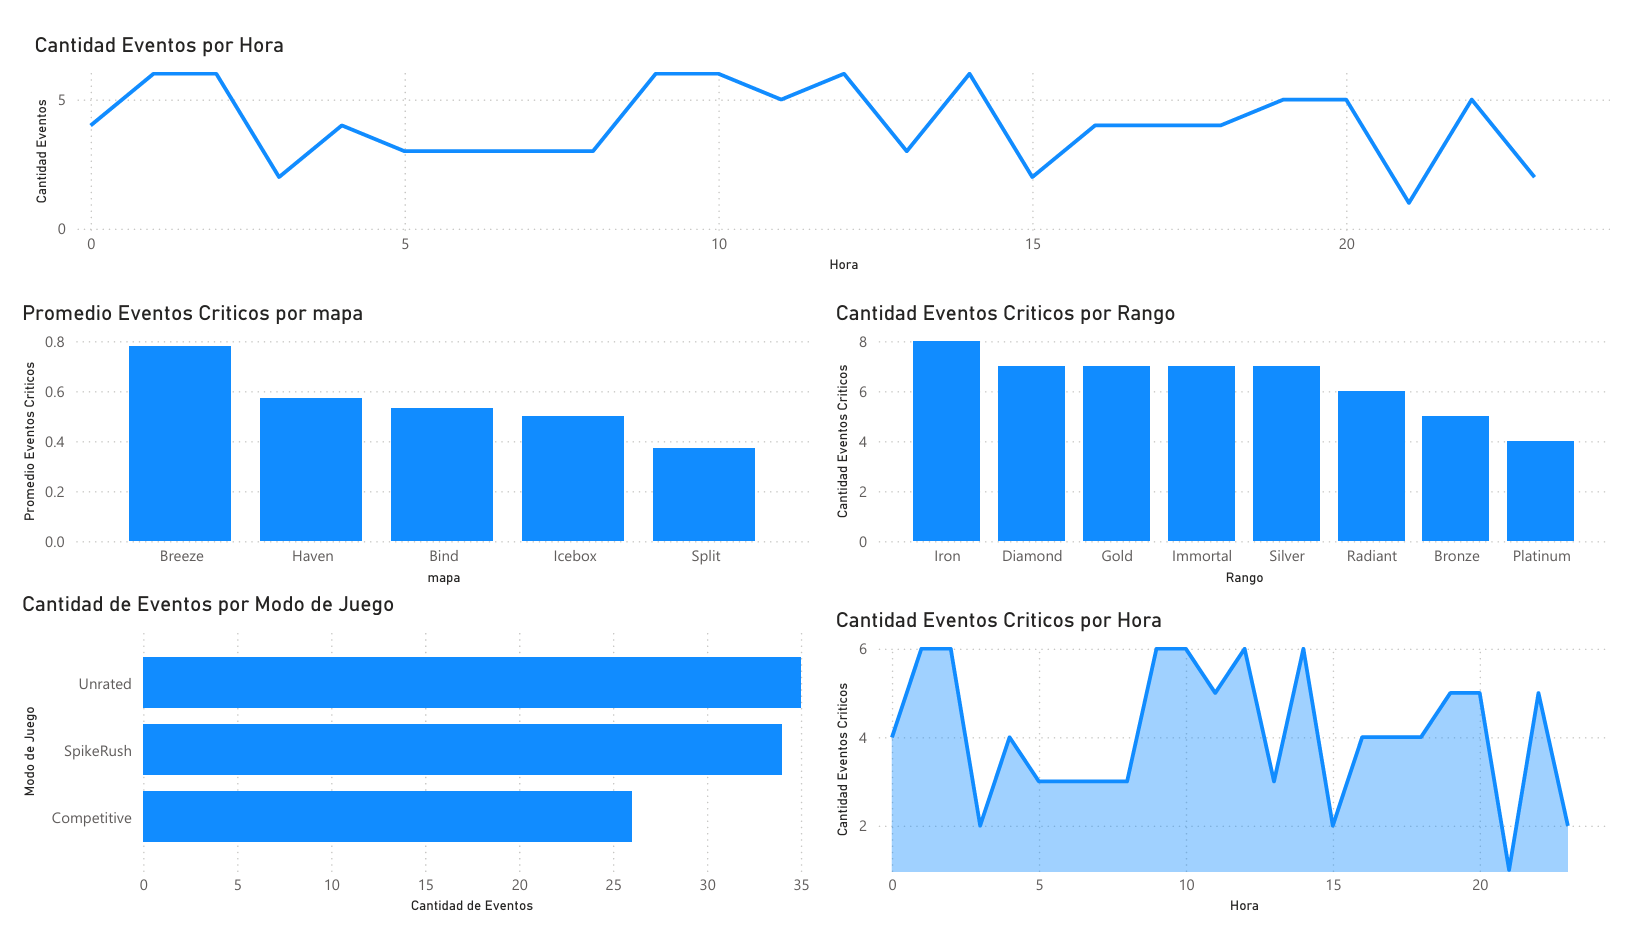